# Space Invaders

# Weights & Biases x Qualcomm - SpaceInvaders Challenge

We’re excited to announce the W&B [SpaceInvaders](https://gym.openai.com/envs/SpaceInvaders-v0/) Challenge, a reinforcement learning competition. Your goal is to train reinforcement learning agents in OpenAI's gym environment. The contestants with the top 3 scores will receive prizes and be invited to present their solutions to the community. The challenge is open to Qualcomm employees only.

This notebook contains code for loading the gym environment, preprocessing data, and calculating & logging the cumulative average reward metrics.

![](https://thumbs.gfycat.com/CookedFriendlyAntarcticfurseal-size_restricted.gif)

## Running this notebook
1. Click "Open in playground" to create a copy of this notebook for yourself.
2. Save a copy in Google Drive for yourself.
3. To enable a GPU, please click Edit > Notebook Settings. Change the "hardware accelerator" to GPU.
4. Step through each section, pressing play on the code blocks to run the cells.
5. Add your own model code.

## Submissions
You may submit your entries [here](https://app.wandb.ai/wandb/spaceinvaders-challenge/benchmark/submit). You'll need a Weights & Biases account to make submissions.

Each run must include the following files:

- Model file generated by [wandb.save()](https://docs.wandb.com/library/python/save)
- Model training script (.py file or notebook)
- Any other files necessary to recreate the model

**Please ensure that you log your model file and all files necessary to recreate the model in your run using [wandb.save()](https://docs.wandb.com/library/python/save). Without this, we will be unable to evaluate your model.**

Also please ensure that your code is not in a public repo, but is visible to us by adding 'lavanyashukla' as a collaborator to your repo. We will use the model saved in the submitted run to recreate the model and evaluate it across the 5 random seeds.

## Evaluation
Your objective is to maximize the best 100-episode average reward. This means your model will play the game for 100 episodes, and we will calculate a running average of the cumulative reward gained as each of the episodes is played. After 100 episodes, this cumulative running average will be your final score for the run.

We encourage you to submit as many runs as you like. To verify results, we will pick the top 5-10 submissions as ranked by the evaluation metric (best 100-episode average reward), and run these agents through the SpaceInvaders environment. We will evaluate how the agents do across 5 randomly generated seeds. This means, your agent will be run for 100 episodes with 5 different seeds and generate a best 100-episode average reward for each seed. We will take the average of these scores to get the final best 100-episode average reward.

Entries will be ranked from highest to lowest by the best 100-episode average reward received across the 5 seeds.

For more details, please visit the [competition website](https://app.wandb.ai/wandb/spaceinvaders-challenge/benchmark/).

In [1]:
!pip install gym pyvirtualdisplay -qq
!pip install folium==0.2.1
!apt-get install -y xvfb python-opengl ffmpeg -qq

!apt-get update -qq
!apt-get install cmake -qq
!pip install --upgrade setuptools -qq
!pip install ez_setup -qq

     |████████████████████████████████| 71kB 2.3MB/s 
  Created wheel for folium: filename=folium-0.2.1-cp36-none-any.whl size=79979 sha256=5e34e7c1b3708f724f7f3c8a34a58ed20294bd4112de410cd5ad095261f3f301
  Stored in directory: /root/.cache/pip/wheels/b8/09/f0/52d2ef419c2aaf4fb149f92a33e0008bdce7ae816f0dd8f0c5
Successfully built folium
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
Selecting previously unselected package python-opengl.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [2]:
!python -V

Python 3.6.9


In [2]:
!pip install --upgrade wandb -qq

     |████████████████████████████████| 1.4MB 2.7MB/s 
     |████████████████████████████████| 102kB 11.1MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 460kB 49.7MB/s 
     |████████████████████████████████| 112kB 41.2MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 


In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(30)

import numpy as np
import random
import math
import queue
import glob
import io
import os
import cv2
import base64
import tensorflow as tf
import threading
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from collections import deque
from datetime import datetime
import keras

from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from time import sleep
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

# import wandb
import wandb

Using TensorFlow backend.


## Preprocessing - crop images, convert them to 1D black and white image tensors

- Image dimensions - (210, 160, 3)
- Output dimensions - (88, 80, 1)


In [0]:
color = np.array([210, 164, 74]).mean()

def preprocess_frame(obs):
    # Crop and resize
    img = obs[25:201:2, ::2]

    # Convert to greyscale
    img = img.mean(axis=2).astype(np.uint8)

    # Improve contrast
    img[img==color] = 0    

    # Reshape to 80*80*1
    img = img.reshape(88,80)

    return np.atleast_3d(img)

## Initialize gym environment and explore game screens


In [5]:
env = gym.make("SpaceInvaders-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print("Actions available(%d): %r"%(env.action_space.n, env.env.get_action_meanings()))

Actions available(6): ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


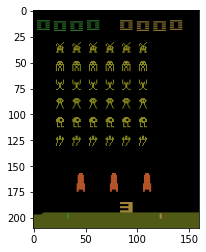

In [6]:
observation = env.reset()
# Game Screen
for i in range(11):
  if i > 9:
    plt.imshow(observation)
    plt.show()
  observation, _, _, _ = env.step(1)

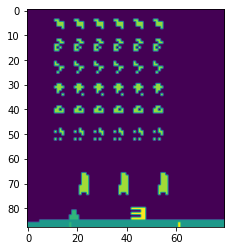

In [7]:
# Preprocessed Game Screen
obs_preprocessed = preprocess_frame(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()

Initialize global macros.

In [0]:
tf.keras.backend.clear_session()

MAX_EPISODE_FRAMES = 18000
GAMMA = 0.99
LAMBDA = 0.99
EVAL_FREQ = 50000
T_MAX = 4000000
T_MAX_SMALL = 5
NO_OP_STEPS = 30
FRAME_SKIP = 1 # Set to 1 to disable frame-skip
FRAME_HISTORY = 4
HIDDEN_UNITS = 256
LEARNING_RATE = 1e-4
NUM_OF_THREADS = 8

The Atari_env is a custom wrapper around the gym Atari environment. This is done mainly to support the "no_op" steps and "frame_skip" steps suggested in the paper.

In [0]:
class Atari_env(object):
  def __init__(self, atari_env, frame_skip, no_op_steps, frame_history):
    self.env = gym.make(atari_env)
    self.frame_skip = frame_skip
    self.no_op_steps = no_op_steps
    self.frame_history = frame_history
    self.state = None

  def reset(self, evaluation=False):
    frame = self.env.reset()
    if evaluation:
      for _ in range(random.randint(0, self.no_op_steps)):
        frame, _, _, _ = self.env.step(0)
    processed_frame = preprocess_frame(frame)    
    self.state = np.repeat(processed_frame, self.frame_history, axis=2)
    return np.expand_dims(self.state, axis=0)

  def step(self, action):
    prev_frame = None
    new_frame, reward, terminal, _ = self.env.step(action)        
    for _ in range(1, self.frame_skip):
      if not terminal:
        prev_frame = new_frame
        new_frame, r, terminal, _ = self.env.step(action)
        reward += r

    if prev_frame is not None:
      new_frame = np.maximum.reduce([new_frame, prev_frame])    
        
    processed_new_frame = preprocess_frame(new_frame)
    self.state = np.append(self.state[:,:,1:], processed_new_frame, axis=2)
    return np.expand_dims(self.state, axis=0), reward, terminal

This section implements the classes for our models.
A3cConvModel - Model is made up of 2 convolutional layers followed by a fully connected. The output of the fully connected is shared across 2 separate fully connected layers that form the policy and value function estimations.

In [0]:
def norm_col_init(std=1.0):
  def init(shape, dtype=None, partition_info=None):
    weights = np.random.randn(*shape).astype(np.float32)
    weights *= std / np.sqrt(np.square(weights).sum(axis=0, keepdims=True))
    return tf.constant(weights)
  return init

class A3cConvModel(tf.keras.Model):
  def __init__(self, action_size, hidden_units=256, state_frames_size=4, state_frame_height=88, state_frame_width=80):
    super(A3cConvModel, self).__init__()
    self.action_size = action_size
    self.hidden_units = hidden_units        
    self.state_frames_size = state_frames_size
    self.state_frame_height = state_frame_height
    self.state_frame_width = state_frame_width

    self.input_layer = tf.keras.layers.InputLayer(input_shape=[self.state_frame_height, self.state_frame_width, self.state_frames_size], name="input")
    self.norm_input = tf.keras.layers.Lambda(lambda x : x / 255.0)
    self.conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=[8,8], strides=4,
                                        padding='valid', activation=tf.keras.activations.relu, name='conv1')
    self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=[4,4], strides=2,
                                        padding='valid', activation=tf.keras.activations.relu, name='conv2')
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(units=hidden_units, activation=tf.keras.activations.relu, name='dense')
    self.policy = tf.keras.layers.Dense(units=self.action_size, activation=tf.keras.activations.softmax, 
                                        kernel_initializer=norm_col_init(0.01), name='policy')
    self.value = tf.keras.layers.Dense(units=1, kernel_initializer=norm_col_init(1.0), name='value')

  @tf.function
  def call(self, state_frames):
    inputs = self.input_layer(tf.cast(state_frames, tf.float32))
    norm_inputs = self.norm_input(inputs)
    conv_output1 = self.conv1(norm_inputs)
    conv_output2 = self.conv2(conv_output1)
    flatten_output = self.flatten(conv_output2)
    dense_output = self.dense(flatten_output)
    policy = self.policy(dense_output)
    value = self.value(dense_output)
    return policy, value

The ActorCritic class below will act as a container to hold the neural network model and train it based on input states, actions, advantage values and target rewards. Before invoking the train method below the model's parameters are copied from the global model which is being trained. In the train method the policy and value losses are computed and combined to form the final loss. The gradients are computed based on the final loss, the optimizer then takes in the gradients and will minimize the loss and finally the gradients are applied to the global model's parameters, i.e, the global model is trained based on the loss computed by the ActorCritic agent.

In [0]:
class ActorCritic:
  def __init__(self, global_model, action_size, model='conv', learning_rate=1e-4, hidden_units=256, state_frames_size=4, state_frame_height=88, state_frame_width=80):
    self.global_model = global_model
    self.action_size = action_size    
    if model is 'conv':
      self.model = A3cConvModel(action_size, hidden_units, state_frames_size, state_frame_height, state_frame_width)      
    elif model is 'lstm':
      self.model = None 
    self.learning_rate = learning_rate # need to sample between (1e-4, 1e-2) and anneal to 0
    self.policy_clip_min = 1e-7
    self.policy_clip_max = 1 - self.policy_clip_min
    self.gradient_clip_norm = 40.0
    self.gamma = GAMMA
    self.Lambda = LAMBDA
    self.beta = 0.01
    self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate, decay=0.99)

  def get_policy_value(self, state_frames):    
    policy, value = self.model(state_frames)    
    return policy.numpy(), value.numpy()

  def train(self, policy, baseline_values, rewards, actions, R):
    with tf.GradientTape() as tape:
      # Add 'R' as the last entry of baseline values to help computing 
      # delta(t) for GAE - Generalized Advantage Estimation
      baseline_values.append(R)  
      value_loss = 0
      generalized_advantage = 0          
      for idx in reversed(range(len(rewards))):
        R = rewards[idx] + (self.gamma * R)                
        # Advantage A(s,a) = R(t) - b(s(t)) where r(t`) is all the discounted reward till 
        # timepoint 't' and b(s(t)) is the baseline for the state at timepoint 't'.        
        advantage = (R - baseline_values[idx])
        # The value estimate for the baseline must be as close to the expected rewards as possible. 
        # Thus the value loss will just be the square error loss of the expected target reward and 
        # the value estimate. The advantage already captures the different of R and B(s(t)), so we 
        # just have to take a square of it and divide by 1/2 to get the mean.
        value_loss = value_loss + ((advantage ** 2) * 0.5)      
        # delta_t for GAE
        delta_t = rewards[idx] + self.gamma * baseline_values[idx+1] - baseline_values[idx]
        generalized_advantage = generalized_advantage * self.gamma * self.Lambda - delta_t                
      # We need to find gradients for "log pi[theta](a(t) | s(t))" for 
      # finding the conditional probability of actions given the state.
      log_policy = tf.math.log(tf.clip_by_value(policy, self.policy_clip_min, self.policy_clip_max))
      # We want the log probability value for only the action a(t) that was taken at 't'
      predicted_policy = tf.reduce_sum(tf.multiply(log_policy, tf.one_hot(actions, self.action_size, dtype=tf.float32)), axis=1)                  
      # The inclusion of the baseline in generalized advantage reduces the variance and 
      # wont affect the policy estimation since it is constant wrt policy gradients 'theta'.
      policy_loss = -np.mean(np.multiply(predicted_policy.numpy(), generalized_advantage))      
      # The entropy is added achieving the exploration vs exploitation balance
      # In the DQN and Dueling DDQN - the epsilon-greedy policy was used to achieve this.
      # Higher entropy implies more exploration as the probability distribution is spread
      # evenly across action. Lower entropy implies explotation as the probability
      # distribution is concentrated more on few actions.
      entropy = tf.reduce_sum(tf.multiply(policy, -log_policy))
      # The final loss is just a weighted linear combination of the value loss with
      # policy loss and entropy.      
      loss = (0.5 * value_loss) + policy_loss - (entropy * self.beta)
    # Only the global model is trained as this ActorCritic instance is part
    # of one of many actor-learner agents that are running in parallel over
    # different environments and training a single global model. Before
    # computing the loss and gradients the local model would have been
    # synchronized with the parameters of the global model.
    variables = self.global_model.trainable_variables
    gradients = tape.gradient(loss, variables)
    # The gradients are clipped to a value specified by clip_norm
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, self.gradient_clip_norm)
    # Each actor-learner agent's have their own optimizers instead of a shared optimizer
    self.optimizer.apply_gradients(zip(clipped_gradients, variables))

  def sync_model_parameters(self):
    variables_local = self.model.trainable_variables
    variables_global = self.global_model.trainable_variables    
    for v1, v2 in zip(variables_local, variables_global):
      v1.assign(v2.numpy())

  def save_model(self, name):
    self.model.save(name)

  def load_model(self, name):
    self.model = tf.keras.models.load_model(name)
    print(self.model.summary())

The Actor_Learner_Agent will interact with the atari environment by taking the action provided by the ActorCritic model and in turn providing the state, action, advantage value and target reward inputs to help train the ActorCritic model. There will be on Actor_Learner_Agent instantiated per thread and launched parallely, this will form the "Asynchronous" part of the A3C algorithm.

In [0]:
class Actor_Learner_Agent:
  def __init__(self, agent_idx, global_model, global_env, t_max, gamma):
    self.agent_idx = agent_idx
    self.global_model = global_model
    self.global_env = global_env
    self.t_max = t_max
    self.gamma = gamma
    self.atari_env = Atari_env('SpaceInvaders-v0', FRAME_SKIP, NO_OP_STEPS, FRAME_HISTORY)
    self.action_size = self.atari_env.env.action_space.n
    self.actor_critic = ActorCritic(self.global_model, self.action_size, 'conv', LEARNING_RATE, HIDDEN_UNITS) 
    self.thread = threading.Thread(target=self.run_training, args=())

  def start_thread(self):
    print("Starting agent : ", self.agent_idx)
    self.thread.start()

  def join_thread(self):
    self.thread.join()

  def run_training(self):    
    T = 0
    t = 1
    state = self.atari_env.reset()
    terminal = False      
    episode_reward = 0  
    last_eval = 0
    while T < T_MAX:
      # Synchronize thread-specific ActorCritic model parameters with the global model parameters
      self.actor_critic.sync_model_parameters()
      t_start = t
      mini_batch_policy = []    # To store the policy estimations for the states
      mini_batch_b_values = []  # To store the baseline value estimations for the states
      mini_batch_rewards = []   # To store the rewards obtained for taking the actions in states
      mini_batch_actions = []   # To store the actions taken in states
      while not terminal and (t - t_start) < self.t_max:        
        # Get the policy and value estimates
        policy, value = self.actor_critic.get_policy_value(state)                       
        # Store the policy and baseline value
        mini_batch_policy.append(policy)
        mini_batch_b_values.append(value[0])
        # Perform an action based on the probability distribution of actions from the policy
        action = np.random.choice(self.action_size, p=policy.flatten())
        state, reward, terminal = self.atari_env.step(action) 
        episode_reward += reward       
        # Store the action and reward
        mini_batch_actions.append(action)
        mini_batch_rewards.append(np.clip(reward, -1, 1))        
        # Update counters
        t = t+1 
        T = T+1      

      # R = 0 for terminal state and R = V(s(t)) for non-terminal
      R = 0
      if terminal:                 
        episode_reward = 0         
        terminal = False        
        state = self.atari_env.reset()   
        if self.agent_idx == 0 and (T - last_eval) >= EVAL_FREQ:
          self.run_evaluation()
          last_eval = T     
      else:
        _, value = self.actor_critic.get_policy_value(state)
        R = value[0]

      # Accumulate the gradients of the global model by calculating the loss and optimizing through the ActorCritic model
      self.actor_critic.train(mini_batch_policy, mini_batch_b_values, mini_batch_rewards, mini_batch_actions, R)      
            
    print("Training completed for agent id : ", self.agent_idx, " at T : ", T)      

  def run_evaluation(self):    
    # Synchronize thread-specific ActorCritic model parameters with the global model parameters
    self.actor_critic.sync_model_parameters()
    terminal = False        
    episode = 0
    episode_reward = 0
    state = self.global_env.reset()
    while not terminal and episode < 10:
      policy, value = self.actor_critic.get_policy_value(state)
      action = np.random.choice(self.action_size, p=policy.flatten())
      state, reward, terminal = self.global_env.step(action)
      episode_reward += reward
      if terminal:
        print("Eval episode : ", episode, "total reward : ", episode_reward)
        episode += 1
        episode_reward = 0
        terminal = False
        state = self.global_env.reset()

The execute_training() method will instantiate the "global-model" which will be shared by the "actor-learner agents" to jointly train it, instantiate a "actor-learner agent" per thread and start the threads.

In [0]:
def execute_training(): 
  learner_agents = []
  train_done = False    
  global_env = Atari_env('SpaceInvaders-v0', FRAME_SKIP, NO_OP_STEPS, FRAME_HISTORY)
  global_model = A3cConvModel(global_env.env.action_space.n, HIDDEN_UNITS, FRAME_HISTORY, 88, 80)  

  for agent_id in range(NUM_OF_THREADS):
    learner_agent = Actor_Learner_Agent(agent_id, global_model, global_env, T_MAX_SMALL, GAMMA)    
    learner_agents.append(learner_agent)

  # Start the threads
  for agent in learner_agents:    
    agent.thread.daemon = True
    agent.start_thread()
  
  for agent in learner_agents:
    agent.join_thread()

  print("Back to main thread")
  
if __name__=='__main__':
  execute_training()

Starting agent :  0
Starting agent :  1
Starting agent :  2
Starting agent :  3
Starting agent :  4
Starting agent :  5
Starting agent :  6
Starting agent :  7
Eval episode :  0 total reward :  105.0
Eval episode :  1 total reward :  100.0
Eval episode :  2 total reward :  75.0
Eval episode :  3 total reward :  105.0
Eval episode :  4 total reward :  55.0
Eval episode :  5 total reward :  135.0
Eval episode :  6 total reward :  135.0
Eval episode :  7 total reward :  135.0
Eval episode :  8 total reward :  160.0
Eval episode :  9 total reward :  310.0
Eval episode :  0 total reward :  75.0
Eval episode :  1 total reward :  135.0
Eval episode :  2 total reward :  135.0
Eval episode :  3 total reward :  155.0
Eval episode :  4 total reward :  15.0
Eval episode :  5 total reward :  65.0
Eval episode :  6 total reward :  110.0
Eval episode :  7 total reward :  165.0
Eval episode :  8 total reward :  150.0
Eval episode :  9 total reward :  200.0
Eval episode :  0 total reward :  95.0
Eval e